## https://zhuanlan.zhihu.com/p/32445437

In [47]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [49]:
train = pd.read_csv("train.csv.gz")
test = pd.read_csv("test.csv.gz")
combined = pd.concat([train,test],axis =0, ignore_index =True)
ntrain = train.shape[0]
Y_train = train["SalePrice"]
X_train = train.drop(["Id","SalePrice"],axis=1)

In [52]:
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
SKIPMAP = False

In [51]:
def eda_plot(df=combined[0:ntrain],cols=[],target=Y_train):
    #Usage: eda_plot(df,cols=[],target=""):
    # df: the dataframe
    # cols: the feature columns want to explorate
    # target the target columns want to refer
    if SKIPMAP == False:
        plt.close("all") #clear all plt figure in buffers
        ax_nth =len(cols)
        
        if ax_nth ==0:
            print("No features need print\n")
        elif ax_nth ==1:
            fig,ax =plt.subplots(2,ax_nth,figsize=(ax_nth*4,5),sharex=True)

            for i in range(ax_nth):
                col=cols[i]
                data = df[col]
                #data = data[data.notnull()]
                
                if (data.dtype == np.number):
                    sns.distplot(data[data.notnull()], ax=ax[0],rug=True)
                    sns.regplot(data,target,ax=ax[1])               

                elif data.dtype is np.object:
                    sns.countplot(data[data.notnull()],ax=ax[0])
                    sns.pointplot(x=train[col],y=target,ax=ax[1]);
                else:
                    print(data.dtype)
        else:
            fig,ax =plt.subplots(2,ax_nth,figsize=(ax_nth*4,5))

            for i in range(ax_nth):
                col=cols[i]
                data = df[col]

                if (data.dtype == np.number):
                    sns.distplot(data[data.notnull()], ax=ax[0,i],rug=True)
                    sns.regplot(data,target,ax=ax[1,i])
                    #ax[1,i].set_title(col)

                elif data.dtype== np.object:
                    sns.countplot(data[data.notnull()],ax=ax[0,i])
                    sns.pointplot(x=train[col],y=target,ax=ax[1,i]);
                    #ax[1,i].set_title(col)

        plt.subplots_adjust(hspace=0.1,wspace=0.1)

In [53]:
def trainvstest():
    from scipy.stats import ks_2samp
    tab_combined=pd.concat([train,test],axis=0,keys=["train","test"],names=["sets"])
    tmp_data = tab_combined.head().reset_index(level=0)
    num_cols = tmp_data.select_dtypes(include=["number"]).columns
    num_cols = num_cols.drop(["Id", "SalePrice"])
    total_num_cols = len(num_cols[:5])

    for col in num_cols:
        v_ks,p_ks=ks_2samp(train[col],test[col])
        if p_ks<0.2:
            print("KS: {0:,.2f}\t Pvalue {1:.2f}\t {2}".format(v_ks,p_ks,col))
            fig,ax = plt.subplots(1,2,figsize=(8,4))
            stats.probplot(np.log1p(train[col]),plot=ax[0])
            ax[0].set_title("Train__"+col)
            stats.probplot(np.log1p(test[col]),plot=ax[1])
            ax[1].set_title("Test__"+col)
            plt.show()

In [54]:
def cat_col_compress(col, threshold=0.005):
    #copy the code from stackoverflow
    # removes the bind
    dummy_col=col.copy()

    # what is the ratio of a dummy in whole column
    count = pd.value_counts(dummy_col) / len(dummy_col)

    # cond whether the ratios is higher than the threshold
    mask = dummy_col.isin(count[count > threshold].index)

    # replace the ones which ratio is lower than the threshold by a special name
    dummy_col[~mask] = "dum_others"

    return dummy_col

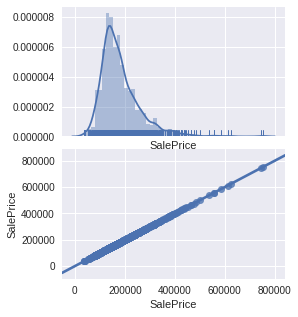

In [55]:
eda_plot(cols=["SalePrice"])

How many features is bad/missing value? The answer is: 35


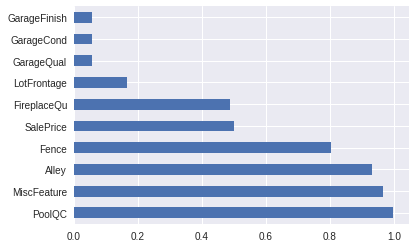

In [56]:
cols_missing_value = combined.isnull().sum()/combined.shape[0]
cols_missing_value = cols_missing_value[cols_missing_value>0]
print("How many features is bad/missing value? The answer is:",cols_missing_value.shape[0])
cols_missing_value.sort_values(ascending=False).head(10).plot.barh()

In [57]:
def pipe_start(df):
    return df.copy()

In [58]:
def pipe_missing_remove(pre_combined):
    
    missing_cols = pre_combined.drop(["Id","SalePrice"],axis=1).isnull().sum()
    remove_cols = missing_cols[missing_cols>(pre_combined.shape[0]*0.4)].index.tolist()
    pre_combined = pre_combined.drop(remove_cols,axis=1)
    
    return pre_combined

In [59]:
def pipe_basic_fillna(df=combined):
    local_ntrain = ntrain
    pre_combined=df.copy()
    
    #print("The input train dimension:\t", pre_combined[0:ntrain].shape)
    #print("The input test dimension:\t", pre_combined[ntrain:].drop("SalePrice",axis=1).shape)
    
    num_cols = pre_combined.drop(["Id","SalePrice"],axis=1).select_dtypes(include=[np.number]).columns
    cat_cols = pre_combined.select_dtypes(include=[np.object]).columns
    

    pre_combined[num_cols]= pre_combined[num_cols].fillna(pre_combined[num_cols].median())
    # Median is my favoraite fillna mode, which can eliminate the skew impact.
    pre_combined[cat_cols]= pre_combined[cat_cols].fillna("NA")
    pre_combined= pd.concat([pre_combined[["Id","SalePrice"]],pre_combined[cat_cols],pre_combined[num_cols]],axis=1)
    return pre_combined  

In [60]:
def pipe_basic_fillna_lotfrontage(df=combined):
    local_ntrain = ntrain
    pre_combined=df.copy()
    
    # below lotfrontage code was inspired by PhilipBallJourney to the top 10%
    # sourcd code https://www.kaggle.com/fiorenza2/journey-to-the-top-10
    
    gb_neigh_LF = pre_combined['LotFrontage'].groupby(pre_combined['Neighborhood'])
    
    for key,group in gb_neigh_LF:
        # find where we are both simultaneously missing values and where the key exists
        lot_f_nulls_nei = pre_combined['LotFrontage'].isnull() & (pre_combined['Neighborhood'] == key)
        # fill in those blanks with the median of the key's group object
        pre_combined.loc[lot_f_nulls_nei,'LotFrontage'] = group.median()

    
    
    num_cols = pre_combined.drop(["Id","SalePrice"],axis=1).select_dtypes(include=[np.number]).columns
     
    cat_cols = pre_combined.select_dtypes(include=[np.object]).columns
    
    
    pre_combined[num_cols]= pre_combined[num_cols].fillna(pre_combined[num_cols].median())
    # Median is my favoraite fillna mode, which can eliminate the skew impact.
    #pre_combined[cat_cols]= pre_combined[cat_cols].fillna("NA")
    
    pre_combined= pd.concat([pre_combined[["Id","SalePrice"]],pre_combined[cat_cols],pre_combined[num_cols]],axis=1)
    return pre_combined  

In [61]:
def pipe_basic_lotfrontage_ratio(df=combined):
    local_ntrain = ntrain
    pre_combined=df.copy()

    #Lotfrontage fill mssing value
    pre_combined["lotfrontage_ratio"] = pre_combined["LotArea"]/pre_combined["LotFrontage"]
    pre_combined["lotfrontage_ratio"] = pre_combined.groupby(["LotShape","LotConfig"])["lotfrontage_ratio"].transform(lambda x: x.fillna(x.median()))
    pre_combined["LotFrontage"] = pre_combined["LotFrontage"].fillna(pre_combined["LotArea"]/pre_combined["lotfrontage_ratio"])
    pre_combined=pre_combined.drop("lotfrontage_ratio",axis=1)

    num_cols = pre_combined.drop(["Id","SalePrice"],axis=1).select_dtypes(include=[np.number]).columns
     
    cat_cols = pre_combined.select_dtypes(include=[np.object]).columns
    
    pre_combined[num_cols]= pre_combined[num_cols].fillna(pre_combined[num_cols].median())
    # Median is my favoraite fillna mode, which can eliminate the skew impact.
    pre_combined[cat_cols]= pre_combined[cat_cols].fillna("NA")
    pre_combined= pd.concat([pre_combined[["Id","SalePrice"]],pre_combined[cat_cols],pre_combined[num_cols]],axis=1)
    return pre_combined  

In [62]:
def pipe_manual_fillna(df=combined):
    from datetime import datetime
    local_ntrain = train.shape[0]
    pre_combined=df.copy()
    
    #print("The input train dimension:\t", pre_combined[0:ntrain].shape)
    #print("The input testdimension:\t", pre_combined[ntrain:].drop("SalePrice",axis=1).shape)
    cols_Qual_Cond_Class=["MSSubClass"]
    pre_combined[cols_Qual_Cond_Class] = pre_combined[cols_Qual_Cond_Class].astype(np.str)
    
    # convert orinal feature as interger and fillna 
    cols_ordinal = ["HeatingQC","KitchenQual","ExterQual",\
                    "ExterCond","FireplaceQu","GarageQual",\
                    "GarageCond","BsmtCond","BsmtQual"]
  
    qal_map = {"Ex":5, #Excellent
               "Gd":4, #Good
               "TA":3, #Average/Typical 
               "Fa":2, #Fair
               "Po":1, #Poor
               "NA":0 # no 
              }
    pre_combined[cols_ordinal]=pre_combined[cols_ordinal].fillna("NA") 
    pre_combined[cols_ordinal]=pre_combined[cols_ordinal].replace(qal_map)
    pre_combined[cols_ordinal]=pre_combined[cols_ordinal].astype(np.int)
  
    #convert basement finish type to ordinal info
    cols_BsmtFinTypeMap = ["BsmtFinType1","BsmtFinType2"]          
    BsmtFinTypeMap ={"GLQ":6,  #Good Living Quarters
             "ALQ":5,  #Average Living Quarters
             "BLQ":4,  #Below Average Living Quarters
             "Rec":3,  #Average Rec Room
             "LwQ":2,  #Low Quality
             "Unf":1,  #unfinshed
             "NA":0,   #No Basement
            }

    pre_combined[cols_BsmtFinTypeMap]=pre_combined[cols_BsmtFinTypeMap].fillna("NA") 
    pre_combined[cols_BsmtFinTypeMap]=pre_combined[cols_BsmtFinTypeMap].replace(BsmtFinTypeMap)
    
    FenceMap ={"GdPrv":4, #Good Privacy
               "MnPrv":3, #Minimum Privacy
               "GdWo":2,#Good Wood
               "MnWw":1,#Minimum Wood/Wire
               "NA":0,#No Fence
              }
    pre_combined["Fence"]=pre_combined["Fence"].fillna("NA") 
    pre_combined["Fence"]=pre_combined["Fence"].replace(FenceMap)
    
    #Lotfrontage fill mssing value
    pre_combined["lotfrontage_ratio"] = pre_combined["LotArea"]/pre_combined["LotFrontage"]
    pre_combined["lotfrontage_ratio"] = pre_combined.groupby(["LotShape","LotConfig"])["lotfrontage_ratio"].transform(lambda x: x.fillna(x.median()))
    pre_combined["LotFrontage"] = pre_combined["LotFrontage"].fillna(pre_combined["LotArea"]/pre_combined["lotfrontage_ratio"])
    pre_combined=pre_combined.drop("lotfrontage_ratio",axis=1)
    
    #fill missing value to misc features
    cols_mis = ["MiscFeature","Alley"]
    pre_combined[cols_mis] = pre_combined[cols_mis].fillna("NA")  # assuming most of house has no such misc feature, so fillNA with NA.
    pre_combined[cols_mis] = pre_combined[cols_mis].astype(np.str)
    
    
    #fill missing value to Garage related features
    #Assuming no garage for thos missing value
    cols_garage = ["GarageType","GarageFinish"]
    pre_combined[cols_garage]= pre_combined[cols_garage].fillna("NA")       
    pre_combined["GarageCars"] =pre_combined["GarageCars"].fillna(pre_combined["GarageCars"].median()).astype(int)
    pre_combined["GarageArea"] =pre_combined["GarageArea"].fillna(pre_combined["GarageArea"].median()).astype(int)
    
    #fill missing value to Basement related features
    mask = pre_combined["TotalBsmtSF"].isnull()
    
    pre_combined["TotalBsmtSF"]=  pre_combined["TotalBsmtSF"].fillna(0)

    mask = (pre_combined["BsmtCond"].isnull().any()) and (pre_combined["TotalBsmtSF"] <= 0)
    pre_combined[["BsmtFinSF1","BsmtFinSF2","BsmtUnfSF"]]= pre_combined[["BsmtFinSF1","BsmtFinSF2","BsmtUnfSF"]].fillna(0)

    cols_bsmt = ["BsmtExposure"]
    BsmtExposureMAP ={"Gd":4, #Good Exposure
                      "Av":3, #Average Exposure (split levels or foyers typically score average or above)
                      "Mn":2, #Mimimum Exposure
                      "No":1, #No Exposure
                      "NA":0, #No Basement
                     }
    pre_combined[cols_bsmt] =pre_combined[cols_bsmt].fillna("NA")    
    pre_combined[cols_bsmt]=pre_combined[cols_bsmt].replace(FenceMap)

    cols_Bsmt_Bath = ["BsmtHalfBath","BsmtFullBath"]
    pre_combined[cols_Bsmt_Bath] =pre_combined[cols_Bsmt_Bath].fillna(pre_combined[cols_Bsmt_Bath].median())

    #fill missing value to MasVnr and Exterior related features
    cols_exterior =["MasVnrType","MasVnrArea","Exterior1st","Exterior2nd"]
    mask = pre_combined["MasVnrType"].isnull()
    #pre_combined.loc[mask,cols_exterior]
    pre_combined["MasVnrType"] = pre_combined["MasVnrType"].fillna("None")
    pre_combined["MasVnrArea"] = pre_combined["MasVnrArea"].fillna(0)
    pre_combined["Exterior1st"] = pre_combined["Exterior1st"].fillna("Other")
    pre_combined["Exterior2nd"] = pre_combined["Exterior2nd"].fillna("Other")
    pre_combined.isnull().sum().sort_values(ascending=False).head(10)
    

    # fill missing value for MSZoning
    cols_Zone =["MSSubClass","MSZoning","Neighborhood"]

    mask = pre_combined["Neighborhood"].str.contains("Mitchel")
    pre_combined["MSZoning"] = pre_combined.loc[mask,["MSZoning"]].fillna("C (all)") #fill the common value of similar localtion
    mask = pre_combined["Neighborhood"].str.contains("IDOTRR")
    pre_combined["MSZoning"] = pre_combined["MSZoning"].fillna("C (all)") #fill the common value of similar localtion
    
    pre_combined["Electrical"] =pre_combined["Electrical"].fillna("Mix")
    pre_combined["Utilities"] = pre_combined["Utilities"].fillna("ELO")
    pre_combined["Functional"] = pre_combined["Functional"].fillna("NA")
    pre_combined["SaleType"] = pre_combined["SaleType"].fillna("Oth")
    pre_combined["PoolQC"] = pre_combined["PoolQC"].fillna("NA")
    
    cols_mis = ["MiscFeature","Alley","Fence"]
    pre_combined[cols_mis] = pre_combined[cols_mis].fillna("NA")  # assuming most of house has no such misc feature, so fillNA with NA.
    pre_combined[cols_mis]=pre_combined[cols_mis].astype(np.str)
    
    #solve Year related feature missing value
    cols_time = ["YearBuilt","YearRemodAdd","GarageYrBlt","MoSold","YrSold"]
    pre_combined["GarageYrBlt"] = pre_combined["GarageYrBlt"].fillna(pre_combined["YearBuilt"]) #use building year for garage even no garage.
       
    return pre_combined

In [63]:
def pipe_fillna_ascat(pre_combined):
    from datetime import datetime
    
    local_ntrain = pre_combined.SalePrice.notnull().sum()

    #convert quality feature to category type 
    #def feature group with same categories value
    cols_Subclass = ["MSSubClass"]
    cols_Zone = ["MSZoning"]
    cols_Overall =["OverallQual","OverallCond"]
    
    cols_Qual = ["BsmtCond","BsmtQual",\
                 "ExterQual","ExterCond",\
                 "FireplaceQu","GarageQual","GarageCond",\
                 "HeatingQC","KitchenQual",
                "PoolQC"]
    cols_BsmtFinType = ["BsmtFinType1","BsmtFinType2"]
    cols_access = ["Alley","Street"]
    cols_condition = ["Condition1","Condition2"]
    cols_fence =["Fence"]
    cols_exposure = ["BsmtExposure"]
    cols_miscfeat = ["MiscFeature"]
    cols_exter = ["Exterior1st","Exterior2nd"]
    cols_MasVnr =["MasVnrType"]
    cols_GarageType = ["GarageType"]
    cols_GarageFinish =["GarageFinish"]
    cols_Functional = ["Functional"]
    cols_Util =["Utilities"]
    cols_SaleType = ["SaleType"]
    cols_Electrical = ["Electrical"]
  
  
    #define the map of categories valus group
    cat_Subclass = ["20",#1-STORY 1946 & NEWER ALL STYLES
                    "30",#1-STORY 1945 & OLDER
                    "40",#1-STORY W/FINISHED ATTIC ALL AGES
                    "45",#1-1/2 STORY - UNFINISHED ALL AGES
                    "50",#1-1/2 STORY FINISHED ALL AGES
                    "60",#2-STORY 1946 & NEWER
                    "70",#2-STORY 1945 & OLDER
                    "75",#2-1/2 STORY ALL AGES
                    "80",#SPLIT OR MULTI-LEVEL
                    "85",#SPLIT FOYER
                    "90",#DUPLEX - ALL STYLES AND AGES
                    "120",#1-STORY PUD (Planned Unit Development) - 1946 & NEWER
                    "150",#1-1/2 STORY PUD - ALL AGES
                    "160",#2-STORY PUD - 1946 & NEWER
                    "180",#PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
                    "190",#2 FAMILY CONVERSION - ALL STYLES AND AGES
                   ]
    cat_Zone = ["A",#Agriculture
                "C (all)",#Commercial #the train/test value is different than the data_description file.
                "FV",#Floating Village Residential
                "I",#Industrial
                "RH",#Residential High Density
                "RL",#Residential Low Density
                "RP",#Residential Low Density Park 
                "RM",#Residential Medium Density
               ]
    cat_Overall = ["10","9","8","7","6","5","4","3","2","1"]
    cat_Qual = ["Ex","Gd","TA","Fa","Po","NA"]
    cat_BsmtFinType = ["GLQ","ALQ","BLQ","Rec","LwQ","Unf","NA"]
    cat_access = ["Grvl","Pave","NA"]
    cat_conditions= ["Artery","Feedr","Norm","RRNn","RRAn","PosN","PosA","RRNe","RRAe"]
    cat_fence = ["GdPrv",#Good Privacy
                "MnPrv",#Minimum Privacy
                "GdWo",#Good Wood
                "MnWw",#Minimum Wood/Wire
                "NA",#No Fence
                ]
    cat_exposure = ["Gd", #Good Exposure
                    "Av", #Average Exposure (split levels or foyers typically score average or above)
                    "Mn", #Mimimum Exposure
                    "No", #No Exposure
                    "NA", #No Basement
                   ]
    cat_miscfeat = ["Elev",#Elevator
                    "Gar2",#2nd Garage (if not described in garage section)
                    "Othr",#Other
                    "Shed",#Shed (over 100 SF)
                    "TenC",#Tennis Court
                    "NA",#None
                   ]
    cat_exter =["AsbShng",#Asbestos Shingles
                "AsphShn",#Asphalt Shingles
                "BrkComm",#Brick Common Brk Cmn BrkComm
                "BrkFace",#Brick Face
                "CBlock",#Cinder Block
                "CementBd",#Cement Board #CementBd was the  data_description value
                "HdBoard",#Hard Board
                "ImStucc",#Imitation Stucco
                "MetalSd",#Metal Siding
                "Other",#Other
                "Plywood",#Plywood
                "PreCast",#PreCast,#
                "Stone",#Stone
                "Stucco",#Stucco
                "VinylSd",#Vinyl Siding
                "Wd Sdng",#Wood Siding
                "WdShing",#Wood Shingles #Wd Shng WdShing
                    ]
    cat_MasVnr =["BrkCmn",#Brick Common
                "BrkFace",#Brick Face
                "CBlock",#Cinder Block
                "None",#None
                "Stone",#Stone
                ]
    cat_GarageType =["2Types",#More than one type of garage
                    "Attchd",#Attached to home
                    "Basment",#Basement Garage
                    "BuiltIn",#Built-In (Garage part of house - typically has room above garage)
                    "CarPort",#Car Port
                    "Detchd",#Detached from home
                    "NA",#No Garage
                    ]
    cat_GarageFinish =["Fin",#Finished
                        "RFn",#Rough Finished,#
                        "Unf",#Unfinished
                        "NA",#No Garage
                      ]
    cat_Functional = ["Typ",#Typical Functionality
                    "Min1",#Minor Deductions 1
                    "Min2",#Minor Deductions 2
                    "Mod",#Moderate Deductions
                    "Maj1",#Major Deductions 1
                    "Maj2",#Major Deductions 2
                    "Sev",#Severely Damaged
                    "Sal",#Salvage only
                    ]
    cat_Util =["AllPub",#All public Utilities (E,G,W,& S)
               "NoSewr",#Electricity, Gas, and Water (Septic Tank)
                "NoSeWa",#Electricity and Gas Only
                "ELO",#Electricity only,#
                ]
    cat_SaleType =["WD",#Warranty Deed - Conventional
                   "CWD",#Warranty Deed - Cash
                    "VWD",#Warranty Deed - VA Loan
                    "New",#Home just constructed and sold
                    "COD",#Court Officer Deed/Estate
                    "Con",#Contract 15% Down payment regular terms
                    "ConLw",#Contract Low Down payment and low interest
                    "ConLI",#Contract Low Interest
                    "ConLD",#Contract Low Down
                    "Oth",#Other
                    ]
    cat_Electrical = ["SBrkr",#Standard Circuit Breakers & Romex
                        "FuseA",#Fuse Box over 60 AMP and all Romex wiring (Average),#
                        "FuseF",#60 AMP Fuse Box and mostly Romex wiring (Fair)
                        "FuseP",#60 AMP Fuse Box and mostly knob & tube wiring (poor)
                        "Mix",#Mixed
                        ]
    
    
    ###########################################################################
    #define the collection of group features &categories value by diction type
    Dict_category={"Qual":[cols_Qual,cat_Qual,"NA","Ordinal"],
                   "Overall":[cols_Overall,cat_Overall,"5","Ordinal"], # It is integer already. no need overwork
                   "BsmtFinType":[cols_BsmtFinType,cat_BsmtFinType,"NA","Ordinal"],
                   "Access":[cols_access,cat_access,"NA","Ordinal"],
                    "Fence":[cols_fence,cat_fence,"NA","Ordinal"],
                   "Exposure":[cols_exposure,cat_exposure,"NA","v"],
                   "GarageFinish":[cols_GarageFinish,cat_GarageFinish,"NA","Ordinal"],
                   "Functional":[cols_Functional,cat_Functional,"Typ","Ordinal"], #fill na with lowest quality
                   "Utility":[cols_Util,cat_Util,"ELO","Ordinal"], # fillNA with lowest quality
            
                   "Subclass":[cols_Subclass,cat_Subclass,"NA","Nominal"],
                   "Zone":[cols_Zone,cat_Zone,"RL","Nominal"], #RL is most popular zone value. "C(all) is the study result"
                   "Cond":[cols_condition,cat_conditions,"Norm","Nominal"],
                   "MiscFeature":[cols_miscfeat,cat_miscfeat,"NA","Nominal"],
                   "Exter":[cols_exter,cat_exter,"Other","Nominal"],
                   "MasVnr":[cols_MasVnr,cat_MasVnr,"None","Nominal"],
                   "GarageType":[cols_GarageType,cat_GarageType,"NA","Nominal"],
                   "SaleType":[cols_SaleType, cat_SaleType,"WD","Nominal"],
                   "Electrical":[cols_Electrical,cat_Electrical,"SBrkr","Nominal"],
                   }
    
   
    #Change input feature type to string, especailly to below integer type  
    pre_combined[cols_Overall] = pre_combined[cols_Overall].astype(str)
    pre_combined[cols_Subclass] = pre_combined[cols_Subclass].astype(str)
    
    
    #fix the raw data mistyping
    exter_map = {"Brk Cmn":"BrkComm", 
                 "CmentBd":"CementBd",
                 "CemntBd":"CementBd",
                 "Wd Shng":"WdShing" }
    pre_combined[cols_exter]=pre_combined[cols_exter].replace(exter_map)
   
    for v in Dict_category.values():
        cols_cat = v[0]
        cat_order =v[1]
        cat_fillnavalue=v[2]
        for col in cols_cat:
            if col in pre_combined.columns:
                pre_combined[col]=pre_combined[col].fillna(cat_fillnavalue) 
                #if not isOrdinal:
                if v[3] =="Nominal":
                    pre_combined[col]=pre_combined[col].astype('category',ordered =True,categories=cat_order)
                elif v[3]=="Ordinal":
                    pre_combined[col]=pre_combined[col].astype('category',ordered =True,categories=cat_order).cat.codes
                    pre_combined[col] = pre_combined[col].astype(np.number)
            

                
    
    #pre_combined[cols_Overall] = pre_combined[cols_Overall].fillna(pre_combined[cols_Overall].median())
    
    #Lotfrontage fill mssing value
    
    pre_combined["LotFrontage"] = pre_combined.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
  
    
    #fill missing value to Garage related features
    #Assuming no garage for thos missing value
    pre_combined["GarageCars"] =pre_combined["GarageCars"].fillna(0).astype(int)
    pre_combined["GarageArea"] =pre_combined["GarageArea"].fillna(0).astype(int)
    
    #fill missing value to Basement related features
    pre_combined[["BsmtFinSF1","BsmtFinSF2","BsmtUnfSF"]]= pre_combined[["BsmtFinSF1","BsmtFinSF2","BsmtUnfSF"]].fillna(0)
    pre_combined["TotalBsmtSF"]= pre_combined["BsmtFinSF1"] + pre_combined["BsmtFinSF2"]+pre_combined["BsmtUnfSF"]
    
    cols_Bsmt_Bath = ["BsmtHalfBath","BsmtFullBath"]
    pre_combined[cols_Bsmt_Bath] =pre_combined[cols_Bsmt_Bath].fillna(0) #assuming mean

    pre_combined["MasVnrArea"] = pre_combined["MasVnrArea"].fillna(0) #filled per study
      
    #solve Year related feature missing value
    #cols_time = ["YearBuilt","YearRemodAdd","GarageYrBlt","MoSold","YrSold"]
    pre_combined["GarageYrBlt"] = pre_combined["GarageYrBlt"].fillna(pre_combined["YearBuilt"]) #use building year for garage even no garage.

    return pre_combined

In [64]:
def pipe_drop_cols(pre_combined):
    pre_combied = pre_combined.drop(['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating'], axis = 1)
    
    return pre_combined

In [65]:
def pipe_extract( pre_combined):
    
    #extract 3 age feature(building, Garage, and remodel)
    pre_combined["BldAge"] = pre_combined["YrSold"] - pre_combined["YearBuilt"]
    pre_combined["GarageAge"] = pre_combined["YrSold"] - pre_combined["GarageYrBlt"]
    pre_combined["RemodelAge"] = pre_combined["YrSold"] - pre_combined["YearRemodAdd"]
    SoldYM_df = pd.DataFrame({"year":pre_combined.YrSold,"month":pre_combined.MoSold.astype("int").astype("object"),"day":1})
    SoldYM_df = pd.to_datetime(SoldYM_df,format='%Y%m%d',unit="D")
    pre_combined["SoldYM"]=SoldYM_df.apply(lambda x: x.toordinal())
    
    #extract total space features
    # three options for calculating the total Square feet. (Garage & basement has very high sknew, remove them )
    #pre_combined["TotalSQF"] = pre_combined["GarageArea"] + pre_combined['TotalBsmtSF']  +pre_combined["GrLivArea"]+pre_combined['1stFlrSF'] + pre_combined['2ndFlrSF']  
    #pre_combined["TotalSQF"] = pre_combined['TotalBsmtSF'] + pre_combined['1stFlrSF'] + pre_combined['2ndFlrSF'] 
    pre_combined["No2ndFlr"] =pre_combined["2ndFlrSF"] ==0
    
    pre_combined["TotalSQF"] = pre_combined['1stFlrSF'] + pre_combined['2ndFlrSF'] +pre_combined["GrLivArea"]
    return pre_combined

In [66]:
def pipe_extract_2ndflr( pre_combined):
    
    #extract 3 age feature(building, Garage, and remodel)
    pre_combined["BldAge"] = pre_combined["YrSold"] - pre_combined["YearBuilt"]
    pre_combined["GarageAge"] = pre_combined["YrSold"] - pre_combined["GarageYrBlt"]
    pre_combined["RemodelAge"] = pre_combined["YrSold"] - pre_combined["YearRemodAdd"]
    SoldYM_df = pd.DataFrame({"year":pre_combined.YrSold,"month":pre_combined.MoSold.astype("int").astype("object"),"day":1})
    SoldYM_df = pd.to_datetime(SoldYM_df,format='%Y%m%d',unit="D")
    pre_combined["SoldYM"]=SoldYM_df.apply(lambda x: x.toordinal())
    
    #extract total space features
    # three options for calculating the total Square feet. (Garage & basement has very high sknew, remove them )
    #pre_combined["TotalSQF"] = pre_combined["GarageArea"] + pre_combined['TotalBsmtSF']  +pre_combined["GrLivArea"]+pre_combined['1stFlrSF'] + pre_combined['2ndFlrSF']  
    #pre_combined["TotalSQF"] = pre_combined['TotalBsmtSF'] + pre_combined['1stFlrSF'] + pre_combined['2ndFlrSF'] 
    pre_combined["No2ndFlr"] =(pre_combined["2ndFlrSF"] ==0).astype(int) # transfer true /false to 1/0
    
    
    pre_combined["TotalSQF"] = pre_combined['1stFlrSF'] + pre_combined['2ndFlrSF'] +pre_combined["GrLivArea"]
    return pre_combined

In [67]:
def pipe_outliers4k(pre_combined):
    
    mask = (pre_combined["GrLivArea"] >3500 ) & (pre_combined["SalePrice"] <300000)
    index_outliers = pre_combined[mask].index
    print(index_outliers)
    pre_combined = pre_combined.drop(index_outliers,axis=0)
    
    return (pre_combined)

In [68]:
def pipe_outliersdrop(pre_combined,ratio =0.002):
    # note, it could done by statsmodel as well. it will explored in future
    ratio =1-ratio
    global ntrain
    ntrain = pre_combined["SalePrice"].notnull().sum()
   
    Y_train = pre_combined["SalePrice"][:ntrain]

    num_cols = pre_combined.select_dtypes(include=[np.number]).columns
    out_df = pre_combined[0:ntrain][num_cols]
    
    top5 = np.abs(out_df.corrwith(Y_train)).sort_values(ascending=False)[:5]

    #eda_plot(df=pre_combined[:ntrain],cols=top5.index)
    limit = out_df["GrLivArea"].quantile(ratio)
 
    # limit use to remove the outliers
    #dropindex = out_df[(out_df["GrLivArea"]>4000) & (out_df["SalePrice"]<30000)].index
    dropindex = out_df[out_df["GrLivArea"]>limit].index
    print("dropped index :",dropindex)
    dropped_pre_combined =pre_combined.drop(dropindex)
    #*****************************
    dropped_Y_train = Y_train.drop(dropindex)
    ntrain =dropped_Y_train.shape[0]
    #*****************************
    print("\n\n*****Drop outlier based on ratio > {0:.3f} quantile :".format(ratio))
    #print("New shape of collected data",dropped_pre_combined.shape)
    return dropped_pre_combined

In [69]:
def pipe_drop4cols(pre_combined): 
    cols_drop =['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']
    # the 4 features(columns was identified earlier which missing data >50%)
    #pre_combined, ntrain = customize_fillna_extract_outliersdrop()
    #pre_combined = customize_fillna_extract_outliersdrop()
    for col in cols_drop:
        if col in pre_combined.columns:
            pre_combined = pre_combined.drop(col,axis=1)
    return pre_combined

In [70]:
def pipe_unitprice(pre_combined,unit_price_cols=["ind_price_feet_bld","ind_price_feet_lot"] ):
    #revision add log1p to remove the skew
    
    if unit_price_cols == ["ind_price_feet_bld","ind_price_feet_lot"]:
        pre_combined["ind_price_feet_bld"] = pre_combined["SalePrice"]/pre_combined["TotalSQF"]
        pre_combined["ind_price_feet_lot"] = pre_combined["SalePrice"]/pre_combined["LotArea"]
    elif unit_price_cols == ["ind_price_feet_bld"]:
         pre_combined["ind_price_feet_bld"] = pre_combined["SalePrice"]/pre_combined["TotalSQF"]
            
    elif unit_price_cols == ["ind_price_feet_lot"]:
        pre_combined["ind_price_feet_lot"] = pre_combined["SalePrice"]/pre_combined["LotArea"]
        
    else:
        return pre_combined
    
    #fill_mean = lambda g: g.fillna(g.mean()) 
    #unit_price_cols=["ind_price_feet_bld","ind_price_feet_lot"] 
    
    #for col in unit_price_cols: pre_combined[col] = np.nan #initialize the unit_price cols
    
    grouper0 = ["Neighborhood","YrSold","MoSold"] 
    grouper1 = ["Neighborhood","YrSold"] 
    grouper2 = ["Neighborhood","MoSold"] 
    grouper3 = ["Neighborhood"] 
    groupers={#"g0":grouper0,"g1":grouper1,"g2":grouper2,
              "g3":grouper3,}
    
    for grouper in groupers.values():
    #level 0 fill, mean unit  price based on place
        grp_fill_values= pre_combined.groupby(by=grouper)[unit_price_cols].transform(np.median) #change to median from mena to avoid outliers impact
        if grouper == ["Neighborhood","YrSold","MoSold"]:
            pre_combined[unit_price_cols] = grp_fill_values
        else:
            pre_combined[unit_price_cols]= pre_combined[unit_price_cols].fillna(grp_fill_values)
    
    #in case of any unit price sample still missing value. fill it with all data median value
    pre_combined[unit_price_cols] =pre_combined[unit_price_cols].fillna(pre_combined[unit_price_cols].median())
    
    return pre_combined

In [71]:
def pipe_log_getdummies(pre_combined,skew_ratio=0.75,cat_ratio=0):
    from scipy.stats import skew
    skew_limit =skew_ratio #I got this limit from Kaggle directly. Someone use 1 , someone use 0.75. I just use 0.75 by random and has no detail study yet
    cat_threshold = cat_ratio

  
    num_cols = pre_combined.select_dtypes(include=[np.number]).columns
    cat_cols = pre_combined.select_dtypes(include=[np.object]).columns
    
    #log transform skewed numeric features:
    skewed_Series = np.abs(pre_combined[num_cols].skew()) #compute skewness
    skewed_cols = skewed_Series[skewed_Series > skew_limit].index.values
    
    pre_combined[skewed_cols] = np.log1p(pre_combined[skewed_cols])
    skewed_Series = abs(pre_combined.skew()) #compute skewness
    skewed_cols = skewed_Series[skewed_Series > skew_limit].index.tolist()

  
       
    for col in cat_cols:
        pre_combined[col]=cat_col_compress(pre_combined[col],threshold=cat_threshold) # threshold set to zero as it get high core for all estimatior  except ridge based
     
    pre_combined= pd.get_dummies(pre_combined,drop_first=True)
 
    return pre_combined

In [72]:
def pipe_boxcox_getdummies(pre_combined,skew_ratio=1,cat_ratio=0):
    from scipy.stats import boxcox
    from scipy.special import boxcox1p
    skew_limit =skew_ratio #I got this limit from Kaggle directly. Someone use 1 , someone use 0.75. I just use 0.75 by random and has no detail study yet
    cat_threshold = cat_ratio

  
    num_cols = pre_combined.select_dtypes(include=[np.number]).columns
    cat_cols = pre_combined.select_dtypes(include=[np.object]).columns
    
    #log transform skewed numeric features:
    skewed_Series = np.abs(pre_combined[num_cols].skew()) #compute skewness
    skewed_cols = skewed_Series[skewed_Series > skew_limit].index.values
    print(skew_cols)
    pre_combined[skewed_cols],_= boxcox1p(pre_combined[skewed_cols])
    skewed_Series = abs(pre_combined.skew()) #compute skewness
    skewed_cols = skewed_Series[skewed_Series > skew_limit].index.tolist()
        
    for col in cat_cols:
        pre_combined[col]=cat_col_compress(pre_combined[col],threshold=cat_threshold) # threshold set to zero as it get high core for all estimatior  except ridge based
     
    pre_combined= pd.get_dummies(pre_combined,drop_first=True)
 
    return pre_combined

In [73]:
def pipe_bypass(df,arg1=None,arg2=None):
    return df

In [74]:
def pipe_drop_dummycols(pre_combined):
    cols = ["MSSubClass_160","MSZoning_C (all)"]
    pre_combined=pre_combined.drop(cols,axis=1)
    
    return pre_combined

In [75]:
def add_PcaIca_cols(pre_combined,target_col="SalePrice",n_pca=10,SEED=42):
    from sklearn.decomposition import PCA, FastICA
    n_comp = n_pca
    
    global ntrain 
    
    X_train = pre_combined[:ntrain].drop([target_col],axis=1)
    X_test = pre_combined[ntrain:].drop([target_col],axis=1)
    Y_train = pre_combined[:ntrain][target_col]
    
    # PCA
    pca = PCA(n_components=n_comp, random_state=SEED)
    pca2_results = pca.fit_transform(pre_combined.drop([target_col],axis=1))
  
    # ICA
    ica = FastICA(n_components=n_comp, random_state=SEED)
    ica2_results = ica.fit_transform(pre_combined.drop([target_col],axis=1))

    # Append decomposition components to datasets
    for i in range(1, n_comp+1):
        pre_combined['pca_' + str(i)] = pca2_results[:,i-1]
        pre_combined['ica_' + str(i)] = ica2_results[:,i-1]
    
    return pre_combined

In [76]:
def add_kmean_col(pre_combined,target_col="SalePrice", kmean_col="GrLivArea",n_cluster=10,SEED=42):
    """
    df,target_col="",n_cluster=4, col="X0",SEED=42
    """
    from xgboost import XGBRegressor,XGBClassifier

    #from lightgbm import LGBMRegressor,LGBMClassifier
    from sklearn.cluster import KMeans
    col = kmean_col
    
    global ntrain 
    
    X_train = pre_combined[:ntrain].drop([target_col,"Id"],axis=1)
    X_test = pre_combined[ntrain:].drop([target_col,"Id"],axis=1)
    Y_train = pre_combined[:ntrain][target_col]
    
    class cluster_target_encoder:
    
        def make_encoding(self,df):
            self.encoding = df.groupby('X')['y'].mean()
            
        def fit(self,X,y):
            df = pd.DataFrame(columns=['X','y'],index=X.index)
            df['X'] = X
            df['y'] = y
            self.make_encoding(df)
            
            clust = KMeans(n_cluster,random_state=SEED)
            
            labels = clust.fit_predict(self.encoding[df['X'].values].values.reshape(-1,1))
            df['labels'] = labels
            self.clust_encoding = df.groupby('X')['labels'].median()

        def transform(self,X):
            res = X.map(self.clust_encoding).astype(float)
            return res

        def fit_transform(self,X,y):
            self.fit(X,y)
            return self.transform(X)
        
    enc1 = cluster_target_encoder()
    
    #fit & transform
    labels_train = enc1.fit_transform(X_train[col],Y_train)
    labels_test =  enc1.transform(X_test[col])

    #fill na of label_test
    
    est = XGBClassifier()
    est.fit(X_train.select_dtypes(include=[np.number]),labels_train)
    pred_labels_test = est.predict(X_test.select_dtypes(include=[np.number]))[np.isnan(labels_test)]
    labels_test[np.isnan(labels_test)]  = est.predict(
    X_test.select_dtypes(include=[np.number]))[np.isnan(labels_test)]  
    
    labels_train.name ="Glv_K"
    pre_combined = pd.concat([pre_combined,labels_train],axis=1)
    pre_combined.Glv_K = pre_combined.Glv_K.fillna(labels_test).astype("str")
    #print(pre_combined.shape)
    #pre_combined = pd.get_dummies(pre_combined,columns=["Glv_K"],drop_first=True)
    #print(pre_combined.shape)
    return pre_combined 

In [77]:
def pipe_export(pre_output,name=""):
    
    if (pre_output is None) :
        print("None input! Expect pre_combined dataframe name as parameter")
        return
    elif pre_output.drop("SalePrice",axis=1).isnull().sum().sum()>0:
        print("Dataframe still missing value! pls check again")
        return
    elif name =="" :
        print("Expect preparing option name to generate output file")
        print("The out file name will be [Preparing_Output_<name>_20171029.h5] ")
        return
    else:
        from datetime import datetime
        savetime=datetime.now().strftime("%m-%d-%H_%M")
        directory_name = "./prepare/"
        filename = directory_name + name +"_"+ savetime +".h5"
        local_ntrain = pre_output.SalePrice.notnull().sum()
        pre_train = pre_output[0:local_ntrain]
        pre_test =pre_output[local_ntrain:].drop("SalePrice",axis=1)

        pre_train.to_hdf(filename,"pre_train")
        pre_test.to_hdf(filename,"pre_test")
        #print("\n***Exported*** :{0}".format(filename))
        #print("\ttrain set size :\t",local_ntrain)
        #print("\tpre_train shape:\t", pre_train.shape)
        #print("\tpre_test  shape:\t", pre_test.shape)
        return pre_output

In [78]:
def pipe_rmsetest(pre_combined):
    import pandas as pd
    import numpy as np
    GLOBAL_SEED=42
    NORMALIZE =False
    target_col ="SalePrice"
    nCV=5
    ntrain = pre_combined["SalePrice"].notnull().sum()
    
    X_train = pre_combined[:ntrain].drop([target_col,"Id"],axis=1)
    X_test  = pre_combined[ntrain:].drop([target_col,"Id"],axis=1)
    Y_train = pre_combined[:ntrain][target_col]
    
    
    
    from sklearn.pipeline import make_pipeline,Pipeline
    from sklearn.preprocessing import StandardScaler,Normalizer,RobustScaler

    from sklearn.model_selection import cross_val_score,train_test_split,KFold,cross_val_predict,StratifiedShuffleSplit
    from sklearn.feature_selection import SelectFromModel
    from sklearn.metrics import  make_scorer,mean_squared_error,r2_score
    from sklearn.linear_model import Lasso,ElasticNet,Ridge,BayesianRidge,RANSACRegressor,HuberRegressor,LassoCV
    from sklearn.kernel_ridge import KernelRidge
    from sklearn.svm import SVR,LinearSVR
    from sklearn.ensemble import GradientBoostingRegressor,ExtraTreesRegressor,AdaBoostRegressor
    from xgboost import XGBRegressor
    from lightgbm import LGBMRegressor
    

    LineRig =Ridge(random_state=GLOBAL_SEED,alpha=0.1,max_iter=5000)
    LSVR =SVR(kernel="rbf",C=1,epsilon=0.01,max_iter=5000)
    LLasso = Lasso(random_state=GLOBAL_SEED,max_iter=5000,alpha=0.1)
    LineEN = ElasticNet(random_state=GLOBAL_SEED,alpha=0.1,max_iter=5000)
    
    xgbreg = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=1000,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             seed =GLOBAL_SEED)
    

    LGB =LGBMRegressor(objective='regression',num_leaves=5,
                       learning_rate=0.05, n_estimators=720,
                      bagging_fraction = 0.8,
                       bagging_freq = 5, feature_fraction = 0.2319,
                       feature_fraction_seed=9, bagging_seed=9,
                       min_data_in_leaf =6, min_sum_hessian_in_leaf = 11,random_state=GLOBAL_SEED)
    GBR = GradientBoostingRegressor(loss = 'huber',n_estimators=1000,learning_rate=0.005, 
                                    max_features='sqrt',min_samples_leaf=15,
                                    min_samples_split=10,max_depth=4,
                                    random_state=GLOBAL_SEED) # difficult to use for hyper tuning
   
    
    estimators_list =[
        LineRig,LLasso,LineEN,LSVR #,LGB,xgbreg
                     ] 
    
    for estimator in estimators_list :
        
        name = type(estimator).__name__
        pipe = make_pipeline(
            StandardScaler(),
            SelectFromModel(LassoCV(), threshold=1e-5),
            estimator)
                
        np.random.seed(GLOBAL_SEED)
        
        cv_scores = cross_val_score(pipe,X_train,Y_train,cv=nCV,scoring ="neg_mean_squared_error" ) 
        
        mean_score =np.sqrt( -cv_scores).mean()
        
        
        print("{0:.4f} \t\t{1}".format(mean_score,name))
        
    return pre_combined

In [80]:
pipe = [pipe_start,pipe_bypass,\
        pipe_fillna_ascat,pipe_drop_cols,\
        pipe_drop4cols,pipe_outliersdrop,\
        pipe_extract,pipe_log_getdummies, \
        pipe_rmsetest,pipe_bypass]

pipe_outlier4k = [pipe_fillna_ascat,pipe_drop_cols,\
              pipe_drop4cols,pipe_outliers4k,\
              pipe_extract,pipe_bypass,\
              pipe_log_getdummies,pipe_bypass, \
              pipe_bypass,
              pipe_rmsetest,pipe_export]

pipe_1169 = [pipe_start,pipe_fillna_ascat,
             pipe_drop4cols,pipe_outliers4k,
            pipe_extract,pipe_bypass,
             pipe_log_getdummies,pipe_drop_dummycols,
            pipe_bypass,
            pipe_rmsetest,pipe_export]


#PIPE_fillna_ascat_drop4cols_outliersdrop_extract_log_getdummies_drop_dummycols_export_r2test_11-08-10_
pipes = [pipe_1169,pipe_outlier4k   ]

for i in range(len(pipes)):
    print("*"*10,"\n")
    pipe_output=pipes[i]
    output_name ="_".join([x.__name__[5:] for x in pipe_output if x.__name__ is not "pipe_bypass"])
    output_name = "PIPE_" +output_name
    print(output_name)
    tmp = (combined.pipe(pipe_output[0])
             .pipe(pipe_output[1])
             .pipe(pipe_output[2])
             .pipe(pipe_output[3])
             .pipe(pipe_output[4])
             .pipe(pipe_output[5])          
             .pipe(pipe_output[6])
             .pipe(pipe_output[7])
             .pipe(pipe_output[8])          
             .pipe(pipe_output[9])
            .pipe(pipe_output[10],output_name)
            )

********** 

PIPE_start_fillna_ascat_drop4cols_outliers4k_extract_log_getdummies_drop_dummycols_rmsetest_export
Int64Index([523, 1298], dtype='int64')
0.1169 		Ridge
0.2058 		Lasso
0.1601 		ElasticNet
0.1586 		SVR
********** 

PIPE_fillna_ascat_drop_cols_drop4cols_outliers4k_extract_log_getdummies_rmsetest_export
Int64Index([523, 1298], dtype='int64')
0.1132 		Ridge
0.2058 		Lasso
0.1602 		ElasticNet
0.1546 		SVR


In [81]:
from datetime import datetime
from time import time
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

handler = logging.FileHandler('hello.log')
handler.setLevel(logging.INFO)
 
# create a logging format
 
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
 
# add the handlers to the logger
 
logger.addHandler(handler)
GLOBAL_SEED=42
GLOBAL_VERBOSE=2
#GLOBAL_SEED=np.random.randint(100)
print(GLOBAL_SEED)
GLOBAL_TMP_FOLDER ="."
SKIPMAP=True
NORMALIZE =False
import os
h5files = []
folders =[#"./prepare/submitted & score =0.11699/",
          "./prepare/"]
for folder in folders:
    flist = os.listdir(folder)
    files = [folder+x for x in flist if x.endswith(".h5")]
    h5files.extend(files)
logger.info(h5files)

INFO:__main__:['./prepare/PIPE_start_fillna_ascat_drop4cols_outliers4k_extract_log_getdummies_drop_dummycols_rmsetest_export_04-08-13_37.h5', './prepare/PIPE_fillna_ascat_drop_cols_drop4cols_outliers4k_extract_log_getdummies_rmsetest_export_04-08-13_37.h5']


42


In [82]:
def save_job(estimator,score="None",verbose=0,dataset=""):
    from sklearn.externals import joblib
    from datetime import datetime
    import csv
    
    store_path="./models/"
    
    savetime=datetime.now().strftime("%m%d_%H%M")
    
    if estimator.__class__.__name__ == 'Pipeline':
        model_name = 'Pipeline_' +estimator.named_steps["clf"].__class__.__name__
    else:
        model_name = estimator.__class__.__name__
    filename = store_path + "HT_{0:.4f}_{1}_{2}.model".format(score,model_name,savetime)
    result = joblib.dump(estimator,filename)
     
    with open("tuned_log.csv","a+") as csvfile: 
        writer = csv.writer(csvfile)

        #先写入columns_name
        #writer.writerow(["index","a_name","b_name"])
        #写入多行用writerows
        writer.writerows([[datetime.now(),model_name,score,filename,dataset]])
    if verbose!=0:
        print(filename,"\t", result)
    return

def load_job(filename):
    from sklearn.externals import joblib
    from datetime import datetime
    
    estimator = joblib.load(filename)
    return estimator

In [83]:
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler,Normalizer,RobustScaler

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
#from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score,GridSearchCV, RandomizedSearchCV,train_test_split,KFold,cross_val_predict,StratifiedShuffleSplit
from sklearn.feature_selection import SelectFromModel,VarianceThreshold
from sklearn.metrics import  make_scorer,mean_squared_error,r2_score

from sklearn.decomposition import PCA,FactorAnalysis,TruncatedSVD

from sklearn.linear_model import Lasso,ElasticNet,LinearRegression,Ridge,BayesianRidge,LassoCV,RANSACRegressor,HuberRegressor


from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR,NuSVR,LinearSVR,LinearSVC
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared
from sklearn.neural_network import MLPRegressor

from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingRegressor,ExtraTreesRegressor,AdaBoostRegressor,RandomForestRegressor,ExtraTreesClassifier

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [84]:
# feature selector
#sfm = SelectFromModel(ExtraTreesRegressor(random_state = GLOBAL_SEED))

#line estimators
#LineReg = LinearRegression(NORMALIZE)
LineRig = Ridge(random_state=GLOBAL_SEED,alpha=0.001)
LLasso = Lasso(random_state=GLOBAL_SEED,alpha =0.001)
LineEN = ElasticNet(random_state=GLOBAL_SEED,alpha=0.001)
LBayes = BayesianRidge()

#gradient boost estimator
#****** learning_rate ,n_estimators
xgbreg = XGBRegressor(n_estimators=1000,learning_rate=0.05,
                      subsample=0.5,
                      #colsample_bytree=0.4603, gamma=0.0468, 
                      #max_depth=3, min_child_weight=1.7817, 
                      #reg_alpha=0.4640, reg_lambda=0.8571,
                      # silent=1,
                      nthread = -1,seed=GLOBAL_SEED)

lgbm =LGBMRegressor(objective='regression',
                    learning_rate=0.05, n_estimators=1000,
                    subsample=0.5,
                    #max_bin = 55, bagging_fraction = 0.8,
                    #bagging_freq = 5, feature_fraction = 0.2319,
                    #feature_fraction_seed=9, bagging_seed=9,
                    #min_data_in_leaf =6, min_sum_hessian_in_leaf = 11,
                    random_state=GLOBAL_SEED)

GBR = GradientBoostingRegressor(loss = 'huber',n_estimators=2000,
                                learning_rate=0.05, subsample=0.5,
                               # max_features='sqrt',min_samples_leaf=15,
                               # min_samples_split=10,max_depth=4,
                                random_state=GLOBAL_SEED) # difficult to use for hyper tuning
 

#Tree estimators (learning rate)
ET= ExtraTreesRegressor( random_state=GLOBAL_SEED)
RF = RandomForestRegressor(max_depth=30, n_estimators=500, max_features = 100, oob_score=True, n_jobs=-1, random_state=1234)
#Kernel Ridge
KRidge =KernelRidge(kernel ="polynomial",degree=2,coef0=4 )

#SVM
Lsvr = SVR(kernel="linear",C=0.01,max_iter=1000)

In [85]:
Params_lasso ={"Scaler":[RobustScaler()],
              "selector__threshold":np.logspace(-5,-4,3),
    #"Normer":[None,Normalizer(norm='l2'),Normalizer(norm='l1')],
    "clf__alpha":np.logspace(-5,-1,10),
    #"Sfm__n_components":SVD_n_components,
    #"Sfm__threshold":sfm_threshold,
                      }
Params_Ridge ={"Scaler":[None,RobustScaler()],
               "selector__threshold":np.logspace(-5,-4,3),
    #"Normer":[None,Normalizer(norm='l2'),Normalizer(norm='l1')],
                "clf__alpha":np.logspace(-2,2,5),
    #"Sfm__n_components":SVD_n_components,
    #"Sfm__threshold":sfm_threshold,
        }

Params_ElasticNet={"Scaler":[RobustScaler()],
                   "selector__threshold":np.logspace(-5,-4,3),
                       # "Normer":[None,Normalizer(norm='l2'),Normalizer(norm='l1')],
                       "clf__alpha":np.logspace(-5,-1,10),
                            #"Sfm__n_components":SVD_n_components,
                            #"Sfm__threshold":sfm_threshold,
                           }
Params_SVR={"Scaler":[RobustScaler()],
             "selector__threshold":np.logspace(-5,-4,3),
              "clf__C":np.logspace(-2,0,3),
                     #"clf__kernel":["linear"],
               }

Params_LGBMRegressor={"Scaler":[RobustScaler(),StandardScaler()],
                       "selector__threshold":np.logspace(-5,-4,3),
                      "clf__n_estimators":[500,1000],
                       "clf__learning_rate":np.logspace(-2,-1,2), #学习速率
                              # "Normer":[None,Normalizer(norm='l2'),Normalizer(norm='l1')],
                               #"Sfm__n_components":SVD_n_components,
                               #"Sfm__threshold":sfm_threshold,
                              }

Params_XGBRegressor={"Scaler":[StandardScaler(),RobustScaler()],
                               "selector__threshold":np.logspace(-6,-4,3),
                               "clf__n_estimators":[500,1000],
                               "clf__learning_rate":[0.01,0.1],
                               "clf__reg_alpha":np.logspace(-3,-1,3),
                               "clf__reg_lambda":np.logspace(-2,0,3),
                              }

Params_GradientBoostingRegressor={"Scaler":[RobustScaler(),StandardScaler()],
                                   "selector__threshold":np.logspace(-5,-4,3),
                                   "clf__n_estimators":[500,1000],#学习器个数
                               "clf__learning_rate":np.logspace(-2,-1,2), #学习速率
                                "clf__max_depth":[3,5,7],
                              # "Normer":[None,Normalizer(norm='l2'),Normalizer(norm='l1')],
                               #"Sfm__n_components":SVD_n_components,
                               #"Sfm__threshold":sfm_threshold,
                              }
Params_groups ={"Lasso":Params_lasso,
               "Ridge":Params_Ridge,
               "ElasticNet":Params_ElasticNet,
                "SVR":Params_SVR,
                "LGBMRegressor":Params_LGBMRegressor,
                "XGBRegressor":Params_XGBRegressor,
                "GradientBoostingRegressor":Params_GradientBoostingRegressor,
               }

In [86]:
def make_clf_grids(estimators_list):
    #clf_grids dictionary definition:
    #Key : the estimator name. It is the type(estimator).__name__
    #Value is a list [ x0,x1,x2,x3]
    #value[0] is the estimator it self
    #values[1] is the params_grid to be turned
    #values[2] is the tuned estimator
    #values[3] is the rmse of tuned estimator best test score
    #values[4] is reserved, the predicted result
    
    grids={}
    for x in estimators_list:
        name = (type(x).__name__)
        grids[name]=[x,{},None,None,None]    
        grids[name][1] = Params_groups[name]
    return grids

full_estimators_list =[LineRig,LLasso,LineEN,Lsvr,lgbm,xgbreg,GBR] 
clf_grids = make_clf_grids(full_estimators_list)

In [87]:
def baseline_cols(filename ="",nCV=5):
    from tempfile import mkdtemp
    from shutil import rmtree
    cachedir = mkdtemp(dir=GLOBAL_TMP_FOLDER)

    if filename =="":
        print("Expect the prepared train/test hdf format filename as input parameter")
        return
    
    train = pd.read_hdf(filename,"pre_train")
    test  = pd.read_hdf(filename,"pre_test")
    
    X_train = train.drop(["Id","SalePrice"],axis=1)
    
    Y_train =train.SalePrice
    
    X_test = test.drop(["Id"],axis=1)
    ID_test = test.Id

    result = []
   
  
    all_means =[]
    for i in full_estimators_list:
        logger.info(i)
        cachedir = mkdtemp(dir=GLOBAL_TMP_FOLDER)
        estimator = i
        name = type(estimator).__name__
        #print(name)
        pipe = Pipeline([("Scaler",RobustScaler()),
                         ("selector",SelectFromModel(LassoCV(cv=5),threshold=1e-5)),
                         ("clf",estimator)],memory=None)
        np.random.seed(GLOBAL_SEED)
        
        cv_scores = cross_val_score(pipe,X_train,Y_train,cv=nCV,scoring ="neg_mean_squared_error" ) 
        
        rmtree(cachedir)
        
        mean_score =np.sqrt( -cv_scores).mean()
        save_job(estimator,mean_score,dataset=filename)
        
        print("{0:.4f} \t\t{1}".format(mean_score,name))
        all_means.append(mean_score)
        
                                       
    return np.mean(all_means)
        
def baseline():
    top_base_score =None
    top_base_filename=""


    for file in h5files:
        if os.path.isfile(file):
            print("\n\n","*"*5,file)
            base_score = baseline_cols(file)
            if top_base_score ==None or top_base_score>base_score:
                top_base_score = base_score
                top_base_filename =file
    print("*"*20)
    print("the top baseline score(averge) :=",top_base_score)
    print("the top baseline used filename :=",top_base_filename)
    return top_base_filename
    
%time top_base_filename = baseline()

INFO:__main__:Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001)




 ***** ./prepare/PIPE_start_fillna_ascat_drop4cols_outliers4k_extract_log_getdummies_drop_dummycols_rmsetest_export_04-08-13_37.h5


INFO:__main__:Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False)


0.1142 		Ridge


INFO:__main__:ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=42, selection='cyclic', tol=0.0001, warm_start=False)


0.1133 		Lasso


INFO:__main__:SVR(C=0.01, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=1000, shrinking=True, tol=0.001, verbose=False)


0.1119 		ElasticNet


INFO:__main__:LGBMRegressor(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.05,
       max_bin=255, max_depth=-1, min_child_samples=10, min_child_weight=5,
       min_split_gain=0, n_estimators=1000, nthread=-1, num_leaves=31,
       objective='regression', random_state=42, reg_alpha=0, reg_lambda=0,
       seed=0, silent=True, subsample=0.5, subsample_for_bin=50000,
       subsample_freq=1)


0.1135 		SVR


LightGBMError: b'Unknown parameter: random_state'

In [88]:
def Tuning_clf(name,search_type="",verbose=0, nCV=5,filename =""):
    from tempfile import mkdtemp
    from shutil import rmtree
    
    if filename =="":
        print("Expect the prepared train/test hdf format filename as input parameter")
        return
    
    train = pd.read_hdf(filename,"pre_train")
    test  = pd.read_hdf(filename,"pre_test")
    
    X_train = train.drop(["Id","SalePrice"],axis=1)
    Y_train =train.SalePrice
    # the log transfer has been done in preprocess stage.In order to keep compatible, keep the log_Y_train name
  
    X_test = test.drop(["Id"],axis=1)
    ID_test = test.Id


    result=[]
    estimator = clf_grids[name][0]
    estimator_params=clf_grids[name][1]
    cachedir = mkdtemp(dir=GLOBAL_TMP_FOLDER)
    pipe = Pipeline([("Scaler",None),
                    # ("Normer",None),
                     ("selector",SelectFromModel(LassoCV(cv=10),threshold=1e-5)),
                     ("clf",estimator)],memory=cachedir) 
    
    t0=time()
    
    def params_size(estimator_params):
        size = 0
        nlen=0
        
        for k,v in estimator_params.items():
            size +=len(v)
        return size
        
        
    if search_type =="Grid" or params_size(estimator_params)<=10:
        rsearch = GridSearchCV(pipe, param_grid=estimator_params,scoring ='neg_mean_squared_error',verbose=verbose,cv=nCV,refit =True)
    else:
        rsearch = RandomizedSearchCV(pipe, param_distributions=estimator_params,
                                     scoring ='neg_mean_squared_error',verbose=verbose,
                                     cv=nCV,random_state=GLOBAL_SEED,refit =True)
    
    rsearch.fit(X_train,Y_train)
    rmtree(cachedir)
    #nfeatures =rsearch.best_estimator_.steps[1][1].get_support().sum()
    nfeatures =X_train.shape[1]
    id_best = rsearch.best_index_
    
    mean = rsearch.cv_results_["mean_test_score"][id_best]
    std  = rsearch.cv_results_["std_test_score"][id_best]
    rmse_std = std # The std was just reference as it is std mean.so skip sqrt process
    rmse_mean = np.sqrt(-mean)
    rmse_zp2 =np.sqrt(-(mean)+2*std)
    rmse_zm2 =np.sqrt(-(mean)-2*std)
    rmse_mean, rmse_zp2,rmse_zm2
    
    t1=time()
    #print("********* {1} \t******** completed in: {0:2f} seconds".format(t1-t0,name))
    #print("*"*10)
   
    result.append([filename,"Tuned",name,rmse_mean,rmse_std,rmse_zp2,rmse_zm2,nfeatures,nCV,str(rsearch.best_params_)[:1000]])
    logtime=datetime.now().strftime("%Y-%m-%d-%H:%M")
    print(logtime,"\t",name,"\t","\t{0:.6f}\t{1:0.6f}""\t{2:.6f}\t{3:0.6f}".format(rmse_mean,rmse_std,rmse_zp2,rmse_zm2,),"\n\t",(rsearch.best_params_))
    #param_plot(rsearch.cv_results_,name)
    #learning_curve_plot(rsearch.cv_results_,name)
     
    #result_df = pd.DataFrame(result,columns=["Filename","HyperTuned","estimator", "mean","std","ZP2","ZM2","Nfeatures","nCV","pipe_info"],index=[logtime for i in range(len(clf_grids))])
    #result_df.to_hdf("./result_log_1101_v0.h5", "result",append=True,format="t",min_itemsize = {"Filename":150, "pipe_info" : 1000 })
    
    return rsearch

In [89]:
estimators_names = [x for x in clf_grids.keys()]

for filename in [top_base_filename]:
    if not os.path.isfile(filename):
        print(filename, "not existed")
    else:
        print("\n\n","*"*5,filename)
       
        for name in  estimators_names:
            #print(filename)
            #print(clf_grids[name][1])
            tuned_clf=Tuning_clf(name,verbose=0,nCV=10,filename = filename)
            best_estimator = tuned_clf.best_estimator_

            rmse = np.sqrt(-tuned_clf.best_score_ )
            #Pred_Y=best_estimator.predict(X_test)
            clf_grids[name][2]=best_estimator
            clf_grids[name][3]=rmse
            #clf_grids[name][4]=Pred_Y
            save_job(best_estimator,rmse)

NameError: name 'top_base_filename' is not defined

In [90]:
def rmsle_cv(model,filename =top_base_filename ):
    
    #use the top base score inputed file for ensembling.
    
    n_folds=5
    
    train = pd.read_hdf(filename,"pre_train")
    test  = pd.read_hdf(filename,"pre_test")
    X_train = train.drop(["Id","SalePrice"],axis=1)
    Y_train = train.SalePrice
    
    kf = KFold(n_folds, shuffle=True, random_state=GLOBAL_SEED).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train, Y_train, scoring="neg_mean_squared_error", cv = kf))
    save_job(model,rmse.mean(),top_base_filename)
    return(rmse)

NameError: name 'top_base_filename' is not defined

In [91]:
def predict2csv(model , filename=top_base_filename):
    import os
    import re
    from datetime import datetime
    
    if not os.path.isfile(filename):
        print("Expect filename(h5 format) as input for average tuning")
        return None
    
    print("\n\n","*"*5,filename)
    
    train = pd.read_hdf(filename,"pre_train")
    test  = pd.read_hdf(filename,"pre_test")
    X_train = train.drop(["Id","SalePrice"],axis=1)
    Y_train =train.SalePrice
    X_test =test.drop(["Id"],axis=1)
    ID_test =test["Id"]

    pred_average = model.fit(X_train,Y_train).predict(X_test).tolist()
    #pred_average = model.fit(X_train,Y_train).predict(X_test).tolist()


    Y_pred = np.expm1(pred_average)
    solution = pd.DataFrame()
    solution["Id"] = ID_test
    solution["SalePrice"] = Y_pred

    predict_name = "_stackaverage_"
    savetime=datetime.now().strftime("%m%d_%H%M")
    pre_process_name =re.search("PIPE_(.*).h5",filename).group(1)
    output_filename = "./submit/"+pre_process_name+predict_name+savetime+".csv"

    solution.to_csv(output_filename , index = False)
    print(output_filename)

NameError: name 'top_base_filename' is not defined

In [92]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)  

In [93]:
averaged_models = AveragingModels(models = [clf_grids[x][2] for x in clf_grids.keys()])

predict2csv(averaged_models,top_base_filename)

score = rmsle_cv(averaged_models)

print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

NameError: name 'predict2csv' is not defined

In [94]:
score = rmsle_cv(averaged_models)

NameError: name 'rmsle_cv' is not defined

In [95]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        #print(self.meta_model)
        X=X.values
        y=y.values
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=GLOBAL_SEED)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            #print(i,type(model).__name__)
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        
        return self.meta_model_.predict(meta_features)

In [97]:
predict2csv(clf_grids["Lasso"][2],top_base_filename)
from sklearn.externals import joblib
savetime=datetime.now().strftime("%m%d_%H%M")
joblib.dump(stacked_averaged_models,"Stacked_"+savetime)
joblib.dump(averaged_models,"Average_"+savetime)
print(filename,"\t", result)

NameError: name 'predict2csv' is not defined

In [98]:
def rmsle(estimator):
    train = pd.read_hdf(filename,"pre_train")
    test  = pd.read_hdf(filename,"pre_test")
    X_train = train.drop(["Id","SalePrice"],axis=1)
    X_test = test.drop(["Id"],axis=1)
    Y_train =train.SalePrice
    estimator.fit(X_train,Y_train)
    train_pred = estimator.predict(X_train)
    test_pred = estimator.predict(X_test)
    score = np.sqrt(mean_squared_error(Y_train, train_pred))
    print("final score = {0}".format(score))
    return train_pred,test_pred
    
final_estimators ={"estimator":[stacked_averaged_models ,clf_grids["LGBMRegressor"][2],clf_grids["XGBRegressor"][2]],
                   "names":["Stacked","LGBMRegressor","XGBRegressor"],
                   "train_pred":[None,None,None],
                   "test_pred":[None,None,None],
                  }

for i in range(3):
    name = final_estimators["names"][i]
    estimator = final_estimators["estimator"][i]
   
    train_pred,test_pred = rmsle(estimator)
    final_estimators["train_pred"][i] = train_pred
    final_estimators["test_pred"][i] = test_pred

NameError: name 'stacked_averaged_models' is not defined